#1.Install

In [ ]:
!pip install datasets transformers scikit-learn matplotlib seaborn


#2.Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns


#3.Load datasets

In [ ]:
dataset = load_dataset("shreyaspullehf/emotion_dataset_100k")
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

train_data = dataset["train"].to_pandas()
test_data = dataset["test"].to_pandas()

print("Train size:", len(train_data))
print("Test size:", len(test_data))


Train size: 79796
Test size: 19950


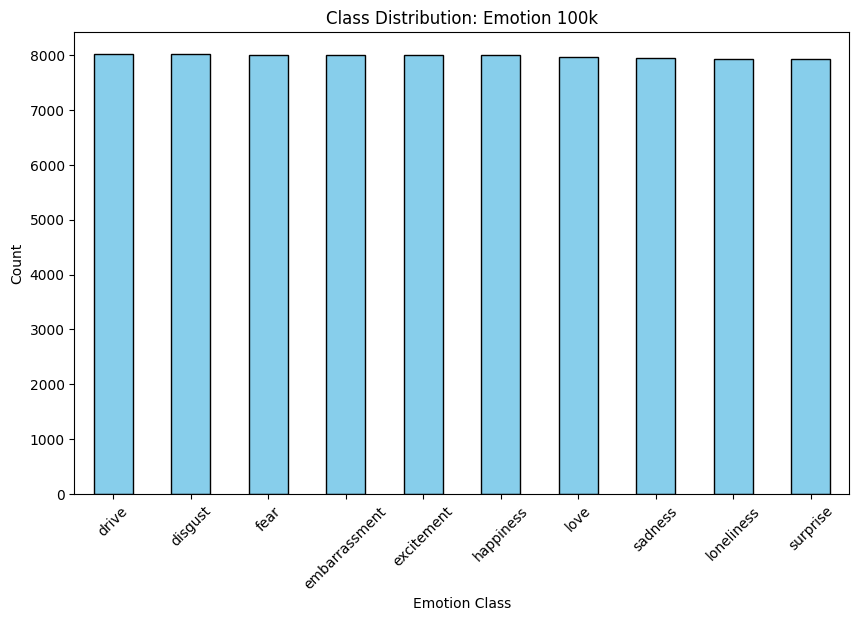

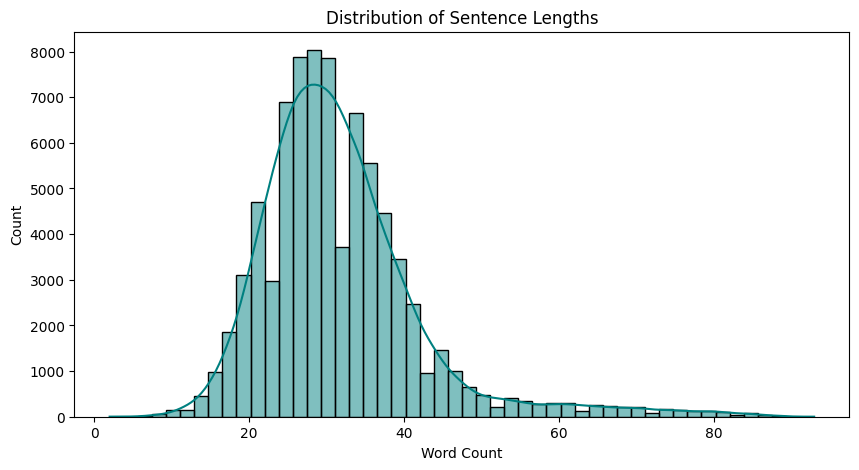

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Class Distribution
plt.figure(figsize=(10, 6))
train_data['emotion'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Class Distribution: Emotion 100k")
plt.xlabel("Emotion Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# 2. Sequence Length Distribution (Crucial for BERT max_length)
train_data['word_count'] = train_data['sentence'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(train_data['word_count'], bins=50, kde=True, color='teal')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Word Count")
plt.show()

#4.Encode Labels

In [ ]:
unique_emotions = sorted(list(set(train_data["emotion"])))

label2id = {label: idx for idx, label in enumerate(unique_emotions)}
id2label = {idx: label for label, idx in label2id.items()}

def encode_labels(example):
    example["emotion"] = label2id[example["emotion"]]
    return example

train_data["emotion"] = train_data["emotion"].map(label2id)
test_data["emotion"] = test_data["emotion"].map(label2id)


#5.Takenization

In [ ]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(
    train_data["sentence"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt"
)

test_encodings = tokenizer(
    test_data["sentence"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt"
)


#6.Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    train_data,
    test_size=0.1,
    random_state=42,
    stratify=train_data["emotion"]  # IMPORTANT for classification
)

print("Final Train:", len(train_data))
print("Validation:", len(val_data))


Final Train: 71816
Validation: 7980


#7.Set Format

In [ ]:
val_encodings = tokenizer(
    val_data["sentence"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt"
)

val_labels = torch.tensor(val_data["emotion"].values)


In [ ]:
import torch

train_labels = torch.tensor(train_data["emotion"].values)
val_labels = torch.tensor(val_data["emotion"].values)
test_labels = torch.tensor(test_data["emotion"].values)


#8.Data Loaders

In [ ]:
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)


#9.Define Model

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

class EmotionClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # CLS token representation
        cls_output = outputs.last_hidden_state[:, 0, :]

        x = self.dropout(cls_output)
        logits = self.classifier(x)

        return logits


#9.Initialize

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = EmotionClassifier(len(label2id)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)


Device: cuda


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


#11.Train

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
epochs = 3   # Keep 1 for speed

train_losses = []
val_losses = []

for epoch in range(epochs):

    print(f"\n===== Epoch {epoch+1} =====")
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_loader):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].long().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_train_loss += loss.item()

        if step % 200 == 0:
            print(f"Step {step}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].long().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"\nTrain Loss: {avg_train_loss:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}")



===== Epoch 1 =====
Step 0/2245 | Loss: 2.2406


KeyboardInterrupt: 

#12.Plot loss

[0.14446040712853928, 0.09269436328920314, 0.06482374316624664]
[0.2257917812433467, 0.2573963983482054, 0.26994335613522263]


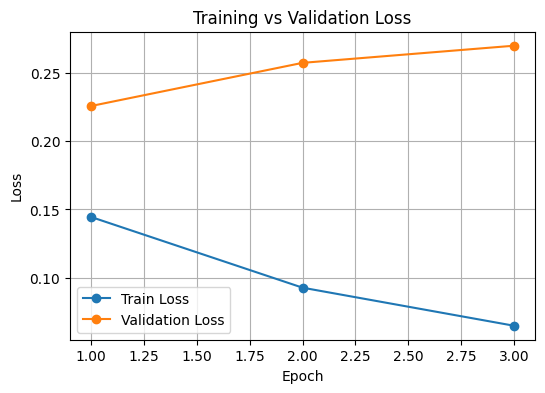

In [ ]:
# plt.figure()
# plt.plot(train_losses, label="Train Loss")
# plt.plot(val_losses, label="Validation Loss")
# plt.legend()
# plt.title("Training vs Validation Loss")
# plt.show()
print(train_losses)
print(val_losses)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



#13.Final Tets Evaluation

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].long().to(device)  # FIXED

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, predictions, average="weighted"
)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9541353383458646
Precision: 0.9543256547210781
Recall: 0.9541353383458646
F1 Score: 0.9541208566433966


#14.Confusion Marix

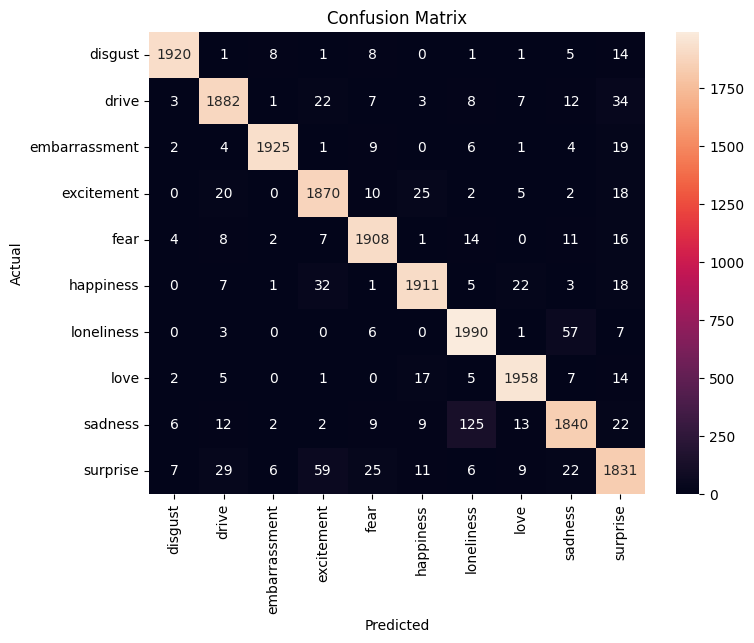

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#15.Inference Function

In [ ]:
def predict_text(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, dim=1)

    return id2label[predicted.item()], confidence.item()


#16.test custom example

In [ ]:
examples = [
    "I feel amazing today!",
    "This is the worst thing ever.",
    "I'm scared of what will happen.",
    "I feel lonely .",
    "That made me furious."
]

for text in examples:
    label, conf = predict_text(text)
    print(f"{text}")
    print(f"Predicted: {label} | Confidence: {conf:.4f}")
    print("-"*50)


I feel amazing today!
Predicted: happiness | Confidence: 0.9996
--------------------------------------------------
This is the worst thing ever.
Predicted: fear | Confidence: 0.4556
--------------------------------------------------
I'm scared of what will happen.
Predicted: fear | Confidence: 1.0000
--------------------------------------------------
I feel lonely .
Predicted: sadness | Confidence: 0.9996
--------------------------------------------------
That made me furious.
Predicted: fear | Confidence: 0.9999
--------------------------------------------------
